In [50]:
%%file src/gurobi_plot.py

import os
import os.path as osp
import argparse
import readfile
import numpy as np
import time
from geopy.distance import great_circle
from gurobipy import *
import pandas as pd
import matplotlib.pyplot as plt


def parse_args():
    arg_parser = argparse.ArgumentParser()

    # input argument options
    arg_parser.add_argument(dest='example_path',
                            type=str,
                            help='Pass the path to the data folder')
    args = arg_parser.parse_args()
    return args

def plot_results(name, avg_dict):
    for state in avg_dict.keys():
        plt.plot(avg_dict[state])

    plt.title(name)
    plt.legend(list(avg_dict.keys()), loc='upper right', shadow=True)
    plt.ylabel('Cost')
    plt.xlabel('Compliance')
    plt.xticks(list(range(11)),map(lambda x: x/10,list(range(11))))
    plt.show()

#---------------------------------------Gurobi-----------------------------------------
def main():
    # get the start time
    st = time.time()
    args = parse_args()
    example_path = args.example_path
    if example_path[-1]!='/':
        example_path+='/'

    #--------------------Districts------------------------------
    districts=readfile.read_districts(example_path,'district.csv')
    district_numpy = []
    for i in districts.keys():
        district_numpy.append([int(districts[i].id)-1,districts[i].coordinates.longitude,districts[i].coordinates.latitude])
    district_numpy = np.array(district_numpy)

    #----------------------Crops---------------------------------
    crops = readfile.read_crops(example_path,'crop.csv')
    crops_numpy = []
    for i,j in zip(crops.keys(),range(len(crops))):
        crops_numpy.append([j,crops[i].transport_cost])
    crops_numpy = np.array(crops_numpy)             #Rows->crops, columns-> transportation_costs
    dist_crop_numpy = [] #rows->districts, columns->dist_no,crop_no,crop_id,cost,yeild,price,max_demand,min_demand
    for district,j in zip(districts.values(),range(len(districts))):
        dist_crop_numpy.append(district.get_crop_details(crops,j))
    dist_crop_numpy = np.array(dist_crop_numpy)

    #-------------------At complince = 1---------------------------
    new_allocation = readfile.read_allocation(example_path,'allocation.csv',crops)
    new_allocation_numpy = []               #rows -> districts, columns -> crops
    for i in new_allocation.allocation.keys():
        temp = []
        for j in crops.keys():
            temp.append(new_allocation.allocation[i][j])  
        new_allocation_numpy.append(temp)
    new_allocation_numpy = np.array(new_allocation_numpy)

    #------------------At complince = 0-----------------------
    standard_allocation=readfile.read_allocation(example_path,'standard_allocation.csv',crops)
    standard_allocation_numpy = []           #rows -> districts, columns -> crops
    for i in standard_allocation.allocation.keys():
        temp = []
        for j in crops.keys():
            temp.append(standard_allocation.allocation[i][j])
        standard_allocation_numpy.append(temp)
    standard_allocation_numpy = np.array(standard_allocation_numpy)
    no_dist= district_numpy.shape[0]
    no_crop = crops_numpy.shape[0]
    distances = np.zeros((no_dist,no_dist))
    cost = dist_crop_numpy[:,:,2]  #Cost per crop per ton
    crop_yield = dist_crop_numpy[:,:,3]     #Yeild tonnes per hectare
    price = dist_crop_numpy[:,:,4]      #price per quintal
    LD = dist_crop_numpy[:,:,6]*(0.7/0.9)         #Minimum demand of district in tonnes (0.7/0.9 for taking 70% of average demand)
    UD = dist_crop_numpy[:,:,5]         #Maximum dwmand of district in tonnes
    TC = crops_numpy[:,1]               #Transportation cost in rupees per ton per km
    # print(f'cost: \n {cost}')
    # print(f'crop_yied: \n{crop_yield}')
    # print(f'price: \n {price}')
    # print(f'LD: \n {LD}')
    # print(f'UD: \n {UD}')
    # print(f'TC: \n {TC}')
    
    d={'Revenue':[],'Production Cost':[],'Transportation':[],'Net Income':[]}
    for c in range(11):
        print(f'---------------------{c/10}-----------------------')
        allocation = (1-c/10)*standard_allocation_numpy + (c/10)*new_allocation_numpy
        for i in range(no_dist):
            for j in range(no_dist):
                    if i == j:
                        # NEEDS TO BE UPDATED : Large value was taken to avoid transportation to self 
                        distances[i,j] = 10**5
                    else: 
                        distances[i,j] = great_circle((district_numpy[i,2],district_numpy[i,1]),(district_numpy[j,2],district_numpy[j,1])).km
        #----------------------Gurobi code----------------------
        model = Model(name=str(c))
        #allocation = model.addVars(no_dist,no_crop,vtype=GRB.CONTINUOUS,lb = 0, name = 'allocation')  #For allocation
        x = model.addVars(no_dist,no_crop*no_dist,vtype=GRB.CONTINUOUS,lb = 0, name = 'x')  #For transportation 
    
        #----------------------------------Adding constarints-------------------------------------------------
        #Split these constraint equations 
        model.addConstrs((allocation[i,j]*crop_yield[i,j]-sum(x[i,j*no_dist+k] for k in range(no_dist))+sum(x[k,j*no_dist+i]\
                        for k in range(no_dist)))>=LD[i,j] for i in range(no_dist) for j in range(no_crop))

        model.addConstrs((allocation[i,j]*crop_yield[i,j]-sum(x[i,j*no_dist+k] for k in range(no_dist))+sum(x[k,j*no_dist+i]\
                        for k in range(no_dist)))<=UD[i,j] for i in range(no_dist) for j in range(no_crop))

        #model.addConstrs((sum(allocation[i,j] for j in range(no_crop))<=max_alloc[i]) for i in range(no_dist))

        COP = quicksum(allocation[i,j]*cost[i,j] for i in range(no_dist) for j in range(no_crop))
        Revenue = quicksum((allocation[i,j]*crop_yield[i,j]-sum(x[i,j*no_dist+k] for k in range(no_dist))+sum(x[k,j*no_dist+i] for k in range(no_dist)))*10*price[i,j] for i in range(no_dist) for j in range(no_crop))
        #Transporting crop j from district i -> k
        Transport_cost = quicksum((TC[j]*distances[i,k]*x[i,j*no_dist+k]) for k in range(no_dist) for i in range(no_dist) for j in range(no_crop))
        obj_fn =  Revenue - COP -  Transport_cost
        model.setObjective(obj_fn,GRB.MAXIMIZE)
        model.optimize()
        #----------------------------For printing the variable values-----------------------------------
        p = 0
        r = 0
        t = 0
        if model.status == GRB.Status.OPTIMAL:
            values = model.getAttr("X", model.getVars())
            values = np.array(values)
            #alloc = values[0:no_dist*no_crop].reshape((no_dist,no_crop))
            alloc=allocation
            transport_qty = values.reshape((no_dist,no_dist*no_crop))
            # print(f'Allocation: \n {alloc}')
            # print(f'Transported quantity: \n {transport_qty}')
            # np.savetxt('transport.csv', transport_qty, delimiter=',')
            stock = np.zeros(alloc.shape)               #Final Stock
            for i in range(no_dist):
                for j in range(no_crop):
                    stock[i,j] = alloc[i,j]*crop_yield[i,j]-sum(transport_qty[i,j*no_dist+k] for k in range(no_dist))+sum(transport_qty[k,j*no_dist+i] for k in range(no_dist))
            # print(f'Stock: \n {stock}')
            p = sum(alloc[i,j]*cost[i,j] for i in range(no_dist) for j in range(no_crop))
            print(f"COP = {p}")
            r = sum((alloc[i,j]*crop_yield[i,j]-sum(transport_qty[i,j*no_dist+k] for k in range(no_dist))+sum(transport_qty[k,j*no_dist+i] for k in range(no_dist)))*10*price[i,j] for i in range(no_dist) for j in range(no_crop))
            print(f'Revenue ={r}')
            t = sum((TC[j]*distances[i,k]*transport_qty[i,j*no_dist+k]) for k in range(no_dist) for i in range(no_dist) for j in range(no_crop))
            print(f'Transport cost = {t}')
            print(f'Profit = {r-p-t}')
        Profit = r-p-t
        d['Revenue'].append(r)
        d['Production Cost'].append(p)
        d['Transportation'].append(t)
        d['Net Income'].append(Profit)
    
    plot_results("Cost & Income vs compliance",d)


if __name__ == '__main__':
    main()

Overwriting src/gurobi_plot.py


In [51]:
!python src/gurobi_plot.py examples/10_crops

---------------------0.0-----------------------
Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-19
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 720 rows, 10800 columns and 41760 nonzeros
Model fingerprint: 0xa68132f7
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+04, 3e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-16, 3e+05]
Presolve removed 360 rows and 360 columns
Presolve time: 0.01s
Presolved: 360 rows, 10770 columns, 21210 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.220e+03
 Factor NZ  : 5.580e+03 (roughly 4 MB of memory)
 Factor Ops : 1.135e+05 (less than 1 second per iteration)
 Threads    : 1

Barrier performed 0 iterations in 0.01 secon

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 720 rows, 10800 columns and 41760 nonzeros
Model fingerprint: 0x09ca7758
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+04, 3e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+05]
Presolve removed 360 rows and 360 columns
Presolve time: 0.01s
Presolved: 360 rows, 10770 columns, 21210 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier performed 0 iterations in 0.01 seconds (0.02 work units)
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Iteration    Objective       Primal Inf.    Dual Inf.      Time
     304    4.5462236e+10   0.000000e+00   0.000000e+00      0s

Solved in 304 iterations and 0.01 seconds (0.02 work units)
Optimal o

In [1]:
%%file src/gurobi_experiment.py

import os
import os.path as osp
import argparse
import readfile
import numpy as np
import time
from geopy.distance import great_circle
from gurobipy import *
import pandas as pd
import matplotlib.pyplot as plt


def parse_args():
    arg_parser = argparse.ArgumentParser()

    # input argument options
    arg_parser.add_argument(dest='example_path',
                            type=str,
                            help='Pass the path to the data folder')
    args = arg_parser.parse_args()
    return args

#---------------------------------------Gurobi-----------------------------------------
def main():
    # get the start time
    st = time.time()
    args = parse_args()
    example_path = args.example_path
    if example_path[-1]!='/':
        example_path+='/'

    #--------------------Districts------------------------------
    districts=readfile.read_districts(example_path,'district.csv')
    district_numpy = []
    for i in districts.keys():
        district_numpy.append([int(districts[i].id)-1,districts[i].coordinates.longitude,districts[i].coordinates.latitude])
    district_numpy = np.array(district_numpy)

    #----------------------Crops---------------------------------
    crops = readfile.read_crops(example_path,'crop.csv')
    crops_numpy = []
    for i,j in zip(crops.keys(),range(len(crops))):
        crops_numpy.append([j,crops[i].transport_cost])
    crops_numpy = np.array(crops_numpy)             #Rows->crops, columns-> transportation_costs
    dist_crop_numpy = [] #rows->districts, columns->dist_no,crop_no,crop_id,cost,yeild,price,max_demand,min_demand
    for district,j in zip(districts.values(),range(len(districts))):
        dist_crop_numpy.append(district.get_crop_details(crops,j))
    dist_crop_numpy = np.array(dist_crop_numpy)

    #-------------------At complince = 1---------------------------
    new_allocation = readfile.read_allocation(example_path,'allocation.csv',crops)
    new_allocation_numpy = []               #rows -> districts, columns -> crops
    for i in new_allocation.allocation.keys():
        temp = []
        for j in crops.keys():
            temp.append(new_allocation.allocation[i][j])  
        new_allocation_numpy.append(temp)
    new_allocation_numpy = np.array(new_allocation_numpy)

    #------------------At complince = 0-----------------------
    standard_allocation=readfile.read_allocation(example_path,'standard_allocation.csv',crops)
    standard_allocation_numpy = []           #rows -> districts, columns -> crops
    for i in standard_allocation.allocation.keys():
        temp = []
        for j in crops.keys():
            temp.append(standard_allocation.allocation[i][j])
        standard_allocation_numpy.append(temp)
    standard_allocation_numpy = np.array(standard_allocation_numpy)
    no_dist= district_numpy.shape[0]
    no_crop = crops_numpy.shape[0]
    distances = np.zeros((no_dist,no_dist))
    cost = dist_crop_numpy[:,:,2]  #Cost per crop per ton
    crop_yield = dist_crop_numpy[:,:,3]     #Yeild tonnes per hectare
    price = dist_crop_numpy[:,:,4]      #price per quintal
    LD = dist_crop_numpy[:,:,6]*(0.7/0.9)         #Minimum demand of district in tonnes (0.7/0.9 for taking 70% of average demand)
    UD = dist_crop_numpy[:,:,5]         #Maximum dwmand of district in tonnes
    TC = crops_numpy[:,1]               #Transportation cost in rupees per ton per km
    # print(f'cost: \n {cost}')
    # print(f'crop_yied: \n{crop_yield}')
    # print(f'price: \n {price}')
    # print(f'LD: \n {LD}')
    # print(f'UD: \n {UD}')
    # print(f'TC: \n {TC}')
    
    
    #--------------Make changes here-------------------
    c=0
    allocation = (c/10)*standard_allocation_numpy + (1-c/10)*new_allocation_numpy
    for i in range(no_dist):
        for j in range(no_dist):
                if i == j:
                    # NEEDS TO BE UPDATED : Large value was taken to avoid transportation to self 
                    distances[i,j] = 10**5
                else: 
                    distances[i,j] = great_circle((district_numpy[i,2],district_numpy[i,1]),(district_numpy[j,2],district_numpy[j,1])).km
    #----------------------Gurobi code----------------------
    model = Model(name='CROP')
    #allocation = model.addVars(no_dist,no_crop,vtype=GRB.CONTINUOUS,lb = 0, name = 'allocation')  #For allocation
    x = model.addVars(no_dist,no_crop*no_dist,vtype=GRB.CONTINUOUS,lb = 0, name = 'x')  #For transportation 

    #----------------------------------Adding constarints-------------------------------------------------
    #Split these constraint equations 
    model.addConstrs((allocation[i,j]*crop_yield[i,j]-sum(x[i,j*no_dist+k] for k in range(no_dist))+sum(x[k,j*no_dist+i]\
                    for k in range(no_dist)))>=LD[i,j] for i in range(no_dist) for j in range(no_crop))

    model.addConstrs((allocation[i,j]*crop_yield[i,j]-sum(x[i,j*no_dist+k] for k in range(no_dist))+sum(x[k,j*no_dist+i]\
                    for k in range(no_dist)))<=UD[i,j] for i in range(no_dist) for j in range(no_crop))

    #model.addConstrs((sum(allocation[i,j] for j in range(no_crop))<=max_alloc[i]) for i in range(no_dist))

    COP = quicksum(allocation[i,j]*cost[i,j] for i in range(no_dist) for j in range(no_crop))
    Revenue = quicksum((allocation[i,j]*crop_yield[i,j]-sum(x[i,j*no_dist+k] for k in range(no_dist))+sum(x[k,j*no_dist+i] for k in range(no_dist)))*10*price[i,j] for i in range(no_dist) for j in range(no_crop))
    #Transporting crop j from district i -> k
    Transport_cost = quicksum((TC[j]*distances[i,k]*x[i,j*no_dist+k]) for k in range(no_dist) for i in range(no_dist) for j in range(no_crop))
    obj_fn =  Revenue - COP -  Transport_cost
    model.setObjective(obj_fn,GRB.MAXIMIZE)
    model.optimize()
    #----------------------------For printing the variable values-----------------------------------
    p = 0
    r = 0
    t = 0
    if model.status == GRB.Status.OPTIMAL:
        values = model.getAttr("X", model.getVars())
        values = np.array(values)
        #alloc = values[0:no_dist*no_crop].reshape((no_dist,no_crop))
        alloc=allocation
        transport_qty = values.reshape((no_dist,no_dist*no_crop))
        # print(f'Allocation: \n {alloc}')
        # print(f'Transported quantity: \n {transport_qty}')
        # np.savetxt('transport.csv', transport_qty, delimiter=',')
        stock = np.zeros(alloc.shape)               #Final Stock
        for i in range(no_dist):
            for j in range(no_crop):
                stock[i,j] = alloc[i,j]*crop_yield[i,j]-sum(transport_qty[i,j*no_dist+k] for k in range(no_dist))+sum(transport_qty[k,j*no_dist+i] for k in range(no_dist))
        # print(f'Stock: \n {stock}')
        p = sum(alloc[i,j]*cost[i,j] for i in range(no_dist) for j in range(no_crop))
        print(f"COP = {p}")
        r = sum((alloc[i,j]*crop_yield[i,j]-sum(transport_qty[i,j*no_dist+k] for k in range(no_dist))+sum(transport_qty[k,j*no_dist+i] for k in range(no_dist)))*10*price[i,j] for i in range(no_dist) for j in range(no_crop))
        print(f'Revenue ={r}')
        t = sum((TC[j]*distances[i,k]*transport_qty[i,j*no_dist+k]) for k in range(no_dist) for i in range(no_dist) for j in range(no_crop))
        print(f'Transport cost = {t}')
        print(f'Profit = {r-p-t}')


if __name__ == '__main__':
    main()

Overwriting src/gurobi_experiment.py


In [2]:
!python src/gurobi_experiment.py examples/10_crops

Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-19
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 720 rows, 10800 columns and 41760 nonzeros
Model fingerprint: 0xa68132f7
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+04, 3e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-16, 3e+05]
Presolve removed 360 rows and 360 columns
Presolve time: 0.01s
Presolved: 360 rows, 10770 columns, 21210 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.220e+03
 Factor NZ  : 5.580e+03 (roughly 4 MB of memory)
 Factor Ops : 1.135e+05 (less than 1 second per iteration)
 Threads    : 1

Barrier performed 0 iterations in 0.01 seconds (0.02 work units)
Barrier solve interrupted -

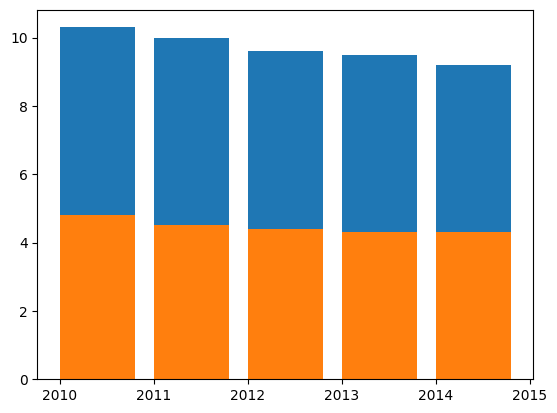

In [1]:
import numpy as np
import matplotlib.pyplot as plt
labels =  np.arange(2010,2015)

scores = [np.array(['10.3', '10', '9.6', '9.5', '9.2'], dtype='<U10'), 
          np.array(['4.8', '4.5', '4.4', '4.3', '4.3'], dtype='<U10')]

bp_dict = plt.bar(labels, list(map(float, scores[0])), align='edge')#, width=-0.4)
bp_dict = plt.bar(labels, list(map(float, scores[1])), align='edge')#, width=0.4)

<BarContainer object of 11 artists>

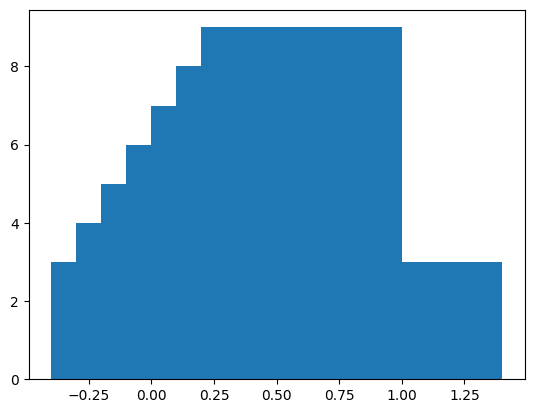

In [11]:
labels = []
a=[3,4,5,6,7,8,9,0,1,2,3]
for x in range(11):
    labels.append(x/10)
# labels=list(labels)
plt.bar(labels, a)

In [5]:
type(labels)

list

In [6]:
type(a)

list

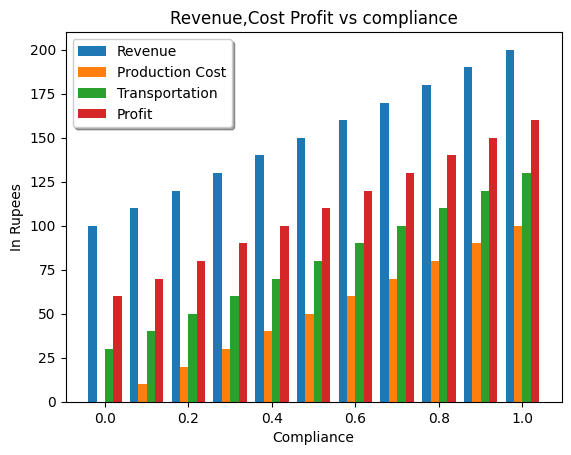

In [9]:
def plot_results(name, avg_dict):
    barWidth = 0.02
    for state,i in zip(avg_dict.keys(),range(len(avg_dict.keys()))):
        # plt.plot(avg_dict[state])
        labels = []
        for x in range(11):
            labels.append((x+i*0.2-0.4)/10)
        plt.bar(labels, avg_dict[state], align='edge', width = barWidth)

    plt.title(name)
    plt.legend(list(avg_dict.keys()), shadow=True)
    plt.ylabel('In Rupees')
    plt.xlabel('Compliance')

d={'Revenue':[100,110,120,130,140,150,160,170,180,190,200],'Production Cost':[0,10,20,30,40,50,60,70,80,90,100],'Transportation':[30,40,50,60,70,80,90,100,110,120,130],'Profit':[60,70,80,90,100,110,120,130,140,150,160]}
plot_results ("Revenue,Cost Profit vs compliance",d)
plt.show()